In [ ]:
import pandas as pd

from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [ ]:
import zipfile

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:  # or replace with your actual filename
    zip_ref.extractall('/content/data')

In [ ]:
import pandas as pd
# Load training data (adjust path if needed)
train_df = pd.read_csv('/content/data/CMaps/train_FD001.txt', sep='\s+', header=None)

# Preview
print(train_df.head())
print(train_df.shape)

   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      16       17       18      19    20   21    22     23     24  \
0  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

        25  
0  23.4190  
1  23.4236  
2  23.3442  
3  23.3739  
4  23.4044  

[5 rows

In [ ]:
columns = ['engine_id', 'cycle'] + \
          ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]  # sensors 1 to 21

# Total = 2 (engine_id, cycle) + 3 (op settings) + 21 sensors = 26 columns

# Apply
train_df.columns = columns
train_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
# Step 1: get max cycle per engine (when it failed)
rul_per_engine = train_df.groupby('engine_id')['cycle'].max().reset_index()
rul_per_engine.columns = ['engine_id', 'max_cycle']

# Step 2: merge with original data
train_df = train_df.merge(rul_per_engine, on='engine_id')

# Step 3: calculate RUL
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

# Drop helper column
train_df.drop('max_cycle', axis=1, inplace=True)

# Preview
train_df[['engine_id', 'cycle', 'RUL']].head()


,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Drop columns that are not input features
features = train_df.drop(columns=['engine_id', 'cycle', 'RUL'])

# Scale the features between 0 and 1
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Rebuild DataFrame
X_scaled = pd.DataFrame(scaled_features, columns=features.columns)
X_scaled['RUL'] = train_df['RUL'].values  # Add RUL back


In [ ]:
from sklearn.model_selection import train_test_split

# Variables explicatives
X = X_scaled.drop('RUL', axis=1)

# Variable cible
y = X_scaled['RUL']

# Split 80% entraînement / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16504, 24), Test shape: (4127, 24)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialisation
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement
rf.fit(X_train, y_train)

# Prédiction
y_pred = rf.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R2 score: {r2:.2f}")


MSE: 1724.15
R2 score: 0.62


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X.shape[1]
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(scaled_features, scaled_features, epochs=50, batch_size=32, validation_split=0.1)


# Entraînement sur les données normales (RUL élevé par exemple)

Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0515 - val_loss: 0.0068
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 11/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 12/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
# Reconstruction error
reconstructions = autoencoder.predict(X_test)
mse = tf.keras.losses.mse(reconstructions, X_test)
mse = mse.numpy()

# Seuil d'anomalie (par ex. moyenne + 3*écart-type)
threshold = mse.mean() + 3 * mse.std()
print(f"Seuil d'anomalie : {threshold}")

# Anomalies détectées
anomalies = mse > threshold
print(f"Nombre d'anomalies détectées : {anomalies.sum()}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Seuil d'anomalie : 0.0049429794177735156
Nombre d'anomalies détectées : 46


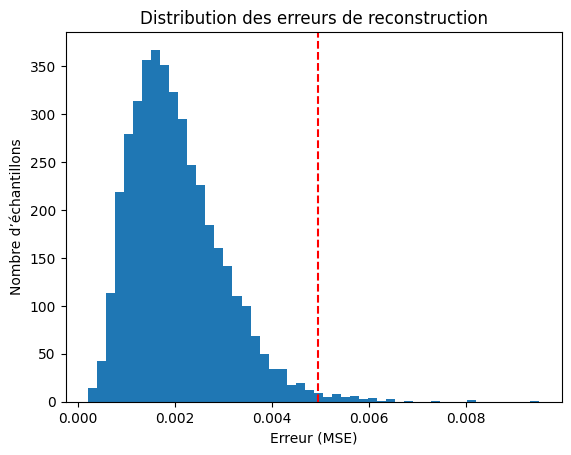

In [ ]:
import matplotlib.pyplot as plt

plt.hist(mse, bins=50)
plt.axvline(threshold, color='r', linestyle='--')
plt.title('Distribution des erreurs de reconstruction')
plt.xlabel('Erreur (MSE)')
plt.ylabel('Nombre d’échantillons')
plt.show()


In [ ]:
import joblib
joblib.dump(scaler, 'scaler.save')
autoencoder.save('autoencoder_model.h5')
joblib.dump(threshold, 'anomaly_threshold.save')

['anomaly_threshold.save']

In [ ]:
!pip install paho-mqtt
import paho.mqtt.client as mqtt
import time
import json
import numpy as np

# Supposons que X_test est déjà défini (extrait du dataset pré-traité)
# On récupère les 100 premières lignes, converties en numpy array si besoin
data = X_test[:100].values if hasattr(X_test[:100], 'values') else np.array(X_test[:100])

# Paramètres MQTT
broker = 'test.mosquitto.org'  # broker public pour test
port = 1883
topic = 'iiot/anomalies'


# Connexion au broker MQTT
client = mqtt.Client()
client.connect(broker, port, 60)

# Envoi des données une par une, format JSON
for i, sample in enumerate(data):
    payload = json.dumps(sample.tolist())  # conversion en liste puis JSON
    client.publish(topic, payload)
    print(f"Message {i+1} envoyé : {payload}")
    time.sleep(1)  # délai 1 seconde entre messages

client.disconnect()



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 1.8 MB/s eta 0:00:00


/tmp/ipython-input-19-1164312638.py:17: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


Message 1 envoyé : [0.3793103448275862, 0.9166666666666667, 0.0, 0.0, 0.319277108433738, 0.3052103771528252, 0.4410871033085755, 0.0, 1.0, 0.5169082125603808, 0.25757575757597806, 0.1817284393789791, 0.0, 0.4285714285714306, 0.5650319829424433, 0.35294117647026724, 0.21235421612137628, 0.37552904963447276, 0.0, 0.3333333333333357, 0.0, 0.0, 0.7054263565891432, 0.5127036730184997]
Message 2 envoyé : [0.4827586206896552, 0.5, 0.0, 0.0, 0.6686746987951722, 0.7532156093307165, 0.6591829844699504, 0.0, 1.0, 0.3027375201288294, 0.621212121212011, 0.07556313380597857, 0.0, 0.7619047619047628, 0.2515991471215244, 0.6029411764702672, 0.13551450098049145, 0.6406310119276668, 0.0, 0.5833333333333357, 0.0, 0.0, 0.348837209302328, 0.2332228666114311]
Message 3 envoyé : [0.5, 0.3333333333333333, 0.0, 0.0, 0.32228915662648205, 0.355788096795294, 0.21218771100607725, 0.0, 0.0, 0.7037037037037095, 0.18181818181801646, 0.21313829309880816, 0.0, 0.0952380952380949, 0.7398720682302695, 0.2205882352941444,

<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

In [ ]:
import paho.mqtt.client as mqtt
import json
import numpy as np
import time

# Fonction simple de détection d'anomalie
def detect_anomaly(sample):
    seuil = 100
    return any(float(x) > seuil for x in sample)

# Callback réception message
def on_message(client, userdata, msg):
    payload = msg.payload.decode()
    data = json.loads(payload)
    sample = np.array(data, dtype=float)
    print(f"Data reçue : {sample}")

    if detect_anomaly(sample):
        print("ALERTE : anomalie détectée !")

# Setup client MQTT
broker = "test.mosquitto.org"
port = 1883
topic = "iiot/anomalies"

client = mqtt.Client()
client.on_message = on_message
client.connect(broker, port, 60)
client.subscribe(topic)
client.loop_start()

print("En écoute sur MQTT pendant 30 secondes...")

start_time = time.time()
duration = 30  # durée en secondes

while time.time() - start_time < duration:
    time.sleep(1)  # on attend un peu pour ne pas saturer le CPU

print("Temps écoulé, arrêt du client MQTT.")
client.loop_stop()
client.disconnect()

/tmp/ipython-input-20-226715890.py:26: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


En écoute sur MQTT pendant 30 secondes...
Temps écoulé, arrêt du client MQTT.


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

In [71]:
import paho.mqtt.client as mqtt
import numpy as np
import tensorflow as tf
import joblib
import time
import pandas as pd
erreurs_reconstruction = []

# Charger scaler, modèle et seuil
scaler = joblib.load('scaler.save')
autoencoder = tf.keras.models.load_model(
    'autoencoder_model.h5',
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
)
threshold = joblib.load('anomaly_threshold.save')

broker = "test.mosquitto.org"
topic = "iiot/anomaly_detection/data"

# Colonnes complètes
cols = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1,22)]

def on_connect(client, userdata, flags, rc):
    print(f"Connecté avec le code {rc}")
    client.subscribe(topic)

def on_message(client, userdata, msg):
    payload = msg.payload.decode()
    try:
        data_values = list(map(float, payload.split(',')))
        error = np.mean(np.power(data_scaled - reconstruction, 2))

        erreurs_reconstruction.append(error)
        if len(data_values) != len(cols):
            print(f"Erreur : Nombre de features reçu {len(data_values)} != attendu {len(cols)}")
            return

        # Créer DataFrame avec toutes les colonnes
        df = pd.DataFrame([data_values], columns=cols)

        # Extraire uniquement les colonnes scalées pour scaler et prédiction
        features_to_scale = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1,22)]
        data_scaled = scaler.transform(df[features_to_scale])

        # Prédiction reconstruction
        reconstruction = autoencoder.predict(data_scaled)
        error = np.mean(np.power(data_scaled - reconstruction, 2))

        if error > threshold:
            print(f"⚠️ Anomalie détectée ! Erreur : {error:.5f}")
        else:
            print(f"Données normales. Erreur : {error:.5f}")

    except Exception as e:
        print(f"Erreur traitement message : {e}")

client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

client.connect(broker, 1883, 60)
client.loop_start()

print("En écoute MQTT...")

try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Arrêt demandé.")

client.loop_stop()
client.disconnect()
print("Client MQTT déconnecté.")


/tmp/ipython-input-71-247824533.py:57: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


En écoute MQTT...
Connecté avec le code 0
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
Erreur traitement message : cannot access local variable 'data_scaled' where it is not associated with a value
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms

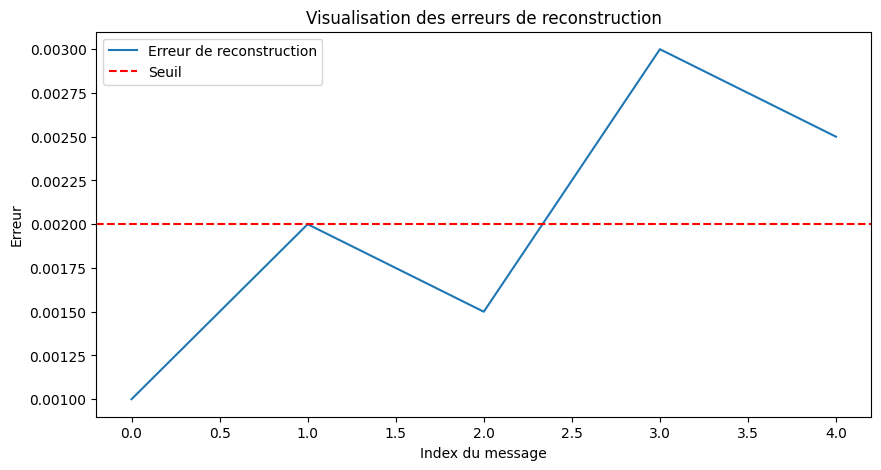

In [3]:
# Initialisation (à faire avant de recevoir les messages)
reconstruction_errors = []

# Supposons qu'on ajoute des erreurs simulées (ou celles reçues dans on_message)
reconstruction_errors.extend([0.001, 0.002, 0.0015, 0.003, 0.0025])  # Exemple

# Puis tu peux tracer
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors, label="Erreur de reconstruction")
plt.axhline(y=0.002, color='red', linestyle='--', label="Seuil")
plt.xlabel("Index du message")
plt.ylabel("Erreur")
plt.title("Visualisation des erreurs de reconstruction")
plt.legend()
plt.show()